# Using OCR Bounding Boxes and Images to evaluate text confidence

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
testfile = '00d0100894168'
img = cv2.imread(f'data/original/img/{testfile}.jpg')
imgdata = pd.read_csv(f"data/interim/ocr/{testfile}.csv")

fig, ax = plt.subplots(5,5,figsize=(40,20))
ctr = 0
for row in imgdata.iterrows():
    if int(row[1]['BB1']) < int(row[1]['BB3']) and int(row[1]['BB2']) < int(row[1]['BB6']):
        slc = img[max(int(row[1]['BB2'])-5, 0):min(int(row[1]['BB6'])+5, img.shape[0]-1), 
            max(int(row[1]['BB1'])-5,0):min(int(row[1]['BB3'])+5, img.shape[1]-1)]
        if ctr < 25:
            ax[ctr//5][ctr%5].imshow(slc)
            ctr += 1
        if ctr == 21:
            break
fig.show()


Corrupt JPEG data: bad Huffman code
/var/folders/pz/bsrlw1051zq7wv21r5cq1y280000gn/T/ipykernel_12098/3792603332.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Error in callback <function flush_figures at 0x13cbc68e0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
import pytesseract as pts

def clarity(slc, debug=False):
    """
    Returns the percentage of confidence, on average, tesseract has for each word
    """
    if debug: fig, ax = plt.subplots(1,3)
    slc2 = cv2.GaussianBlur(slc, (9,9), 1)
    slc2 = cv2.cvtColor(slc2, cv2.COLOR_BGR2GRAY)
    if debug: ax[0].imshow(slc2)
    slc3 = 255 - slc2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,2))
    slc3 = cv2.morphologyEx(slc3, cv2.MORPH_CLOSE, kernel, iterations=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,5))
    slc3 = 255 - cv2.morphologyEx(slc3, cv2.MORPH_CLOSE, kernel, iterations=0)
    slc3 = slc3.astype(np.uint8)
    if debug: ax[1].imshow(slc3)
    _, slc3 = cv2.threshold(slc3, 200, 255, cv2.THRESH_BINARY_INV)
    if debug: ax[2].imshow(slc3)
    text = pts.image_to_data(cv2.cvtColor(slc3, cv2.COLOR_BGR2RGB), output_type='data.frame', config="--psm 7")
    if debug: plt.imshow(slc3)
    text = text[text['text'].notna()]
    if len(text) == 0:
        return [0], [""], ((0, 0, 1, 1),)
    coords = []
    for row in text.iterrows():
        coords.append((int(row[1]['left']), 
            int(row[1]['top']), 
            int(row[1]['width'])+int(row[1]['left']), 
            int(row[1]['height'])+int(row[1]['top'])))

    return list(text['conf']), list(text['text']), coords

print(clarity(slc, debug=True))

In [ ]:
res = []
words = []
bounds = []
for row in imgdata.iterrows():
    if int(row[1]['BB1']) < int(row[1]['BB3']) and int(row[1]['BB2']) < int(row[1]['BB6']):
        slc = img[max(int(row[1]['BB2'])-5, 0):min(int(row[1]['BB6'])+5, img.shape[0]-1), 
            max(int(row[1]['BB1'])-5,0):min(int(row[1]['BB3'])+5, img.shape[1]-1)]
        c, t, b = clarity(slc)
        [res.append(s) for s in c]
        [words.append(s) for s in t]
        [bounds.append((s[0]+int(row[1]['BB1'])-5, s[1]+int(row[1]['BB2'])-5, s[2]+int(row[1]['BB1'])-5, s[3]+int(row[1]['BB2'])-5)) for s in b]
plt.hist(res)
plt.show()

In [ ]:
fig, ax = plt.subplots(4,4,figsize=(30,30))
ctr = 0
print(bounds)
for i in range(len(words)):
    if res[i] < 10:
        if ctr < 16:
            ax[ctr//4][ctr%4].imshow(img[bounds[i][1]:bounds[i][3],bounds[i][0]:bounds[i][2]])
            ax[ctr//4][ctr%4].set_title(words[i] + " " + str(res[i]))
            ctr += 1
fig, ax = plt.subplots(1,1)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

ocrdir = 'data/interim/ocr/'
imgdir = 'data/original/img/'

for filename in os.listdir(ocrdir):
    img = cv2.imread(os.path.join(imgdir, filename[:-4]+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (9,9), 1)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 95, 15)
    imgdata = pd.read_csv(os.path.join(ocrdir, filename))
    confs = []
    fig, ax = plt.subplots(3,3)
    ctr = 0
    for row in imgdata.iterrows():
        slc = img[max(int(row[1]['BB2'])-5, 0):min(int(row[1]['BB6'])+5, img.shape[0]-1), 
            max(int(row[1]['BB1'])-5,0):min(int(row[1]['BB3'])+5, img.shape[1]-1)]
        if ctr < 9:
            ax[ctr//3][ctr%3].imshow(slc)
            ctr += 1
    break

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pytesseract as pts
from cvread import cvread
from tqdm import tqdm
from multiprocessing import Pool

ocrdir = 'data/interim/ocr/'
imgdir = 'data/original/img/'

data = []
confs = []
files = 0
    
with Pool() as p:
    result = p.map(cvread, list(os.listdir(ocrdir)[:20]))

print(result)

00d0142736377.csv
00d0770154989.csv
00d0201817639.csv
00d0243046961.csv
00d0530724847.csv
00d0114666542.csv
00d0696518680.csv
00d0164592408.csv
00d0607552804.csv
00d0602427476.csv
00d0763228450.csv
00d0724729985.csv
00d0945045450.csv
00d0910676977.csv
00d0726102139.csv
00d0206227401.csv
00d0760612254.csv
00d0206117546.csv
00d0749666123.csv
00d0139642641.csv
[[96.289047, 82.829903, 89.555725, 91.210007, 96.005127, 96.813477, 92.097305, 92.919106, 69.670097, 95.956497, 96.669373, 96.044693, 96.151138, 96.238586, 80.429306, 93.057503, 91.586952, 96.290833, 96.660393, 96.495865, 95.890381, 96.204964, 94.410278, 94.803604, 92.800751, 94.809303, 92.60038, 90.948509, 96.469398, 96.596016, 96.180931, 93.850212, 93.258286, 87.536751, 96.143784, 96.021439, 93.733559, 96.568169, 95.714455, 96.46447, 95.757591, 96.438385, 91.120697, 91.120697, 61.908501, 84.435707, 61.208042, 76.197609, 77.903732, 87.127319, 90.696373, 90.603935, 90.603935, 90.080429, 93.261986, 66.944817, 74.82238, 92.725357, 95.

(array([ 80.,  14.,  21.,  16.,  14.,  33.,  18.,  23.,  29.,  40.,  45.,
         30.,  52.,  47.,  72.,  84.,  86., 149., 309., 942.]),
 array([ 0.       ,  4.8498497,  9.6996994, 14.5495491, 19.3993988,
        24.2492485, 29.0990982, 33.9489479, 38.7987976, 43.6486473,
        48.498497 , 53.3483467, 58.1981964, 63.0480461, 67.8978958,
        72.7477455, 77.5975952, 82.4474449, 87.2972946, 92.1471443,
        96.996994 ]),
 <BarContainer object of 20 artists>)

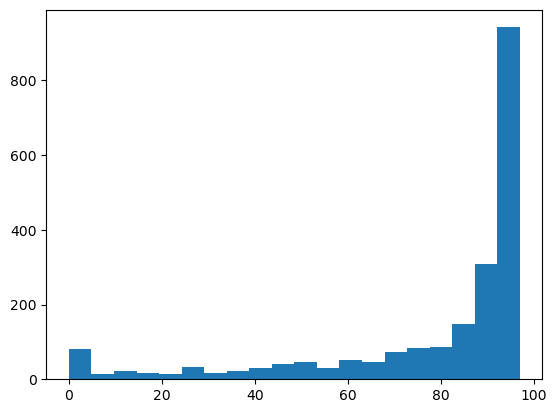

In [17]:
big = []
for r in result:
    for rr in r:
        big.append(rr)
plt.hist(big, bins=20)